## ================================================<br>📘 MLCPD: Universal Schema Dataset Analysis<br>-------------------------------------------------------------------<br>Purpose: Analyze file-level, language-level, and overall statistics of<br>universal schema dataset.<br>================================================

### 1. Setup and Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Notebook aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [3]:
# Define dataset path and languages
DATA_PATH = "final_parquet_output"
languages = [
    "c", "cpp", "c_sharp", "go", "java", "javascript",
    "python", "ruby", "scala", "typescript"
]

### 2. Utility Functions

In [4]:
def get_file_stats(file_path):
    """
    Compute summary statistics for a single Parquet file.
    Returns a dictionary with quantitative metrics.
    """
    df = pd.read_parquet(file_path)
    disk_size = os.path.getsize(file_path)
    mem_size = df.memory_usage(deep=True).sum()
    rows = len(df)

    stats = {
        "file": os.path.basename(file_path),
        "language": df['language'].iloc[0],
        "rows": rows,
        "disk_size_gb": disk_size / 1e9,
        "memory_size_gb": mem_size / 1e9,
        "mean_line_count": df["line_count"].mean(),
        "std_line_count": df["line_count"].std(),
        "mean_ast_nodes": df["ast_node_count"].mean(),
        "std_ast_nodes": df["ast_node_count"].std(),
        "mean_line_length": df["avg_line_length"].mean(),
        "mean_node_density": (df["ast_node_count"] / df["line_count"]).mean(),
        "mean_errors": df["num_errors"].mean(),
        "zero_error_ratio": (df["num_errors"] == 0).mean() * 100
    }
    
    del df # Free memory

    return stats

### 3. File-Level Analysis

In [5]:
file_stats = []
for lang in tqdm(languages, desc="Processing languages"):
    for file_path in glob(f"{DATA_PATH}/{lang}_parsed_*.parquet"):
        file_stats.append(get_file_stats(file_path))

Processing languages: 100%|██████████| 10/10 [07:42<00:00, 46.26s/it]


In [ ]:
df_files = pd.DataFrame(file_stats)
df_files.to_csv("final_statistics/stats_file_level.csv", index=False)
display(df_files.head())

,file,language,rows,disk_size_gb,memory_size_gb,mean_line_count,std_line_count,mean_ast_nodes,std_ast_nodes,mean_line_length,mean_node_density,mean_errors,zero_error_ratio
0,c_parsed_1.parquet,c,175204,2.596300,13.378119,61.444585,65.402605,403.105568,513.234515,28.059679,6.237388,9.018932,42.087509
1,c_parsed_2.parquet,c,175205,2.611630,13.455107,61.889027,66.000759,405.316800,515.834923,28.080004,6.240836,9.059981,41.966268
2,c_parsed_3.parquet,c,175204,2.601944,13.397535,61.592698,65.648709,403.485851,510.398103,28.087397,6.244964,8.961599,42.324947
3,c_parsed_4.parquet,c,175205,2.630473,13.543296,62.111332,66.226149,407.894712,519.423316,28.100790,6.246498,9.046945,42.040467
4,cpp_parsed_1.parquet,cpp,176910,4.613840,24.793147,87.825844,84.966822,744.038963,804.418869,28.121270,8.146935,0.748686,88.641117


In [29]:
# Insert compression ratio column: how much smaller the disk file is vs memory
df_files.insert(
    loc=df_files.columns.get_loc("memory_size_gb") + 1,
    column="compression_ratio",
    value=(df_files["memory_size_gb"] / df_files["disk_size_gb"]).round(2)
)

In [46]:
# If mean_node_density is inf, replace it with (mean_ast_nodes/mean_line_count)
df_files["mean_node_density"] = df_files.apply(
    lambda row: row["mean_ast_nodes"] / row["mean_line_count"]
    if np.isinf(row["mean_node_density"]) else row["mean_node_density"],
    axis=1
)

In [47]:
display(df_files.head(40))

,file,language,rows,disk_size_gb,memory_size_gb,compression_ratio,mean_line_count,std_line_count,mean_ast_nodes,std_ast_nodes,mean_line_length,mean_node_density,mean_errors,zero_error_ratio
0,c_parsed_1.parquet,c,175204,2.596300,13.378119,5.15,61.444585,65.402605,403.105568,513.234515,28.059679,6.237388,9.018932,42.087509
1,c_parsed_2.parquet,c,175205,2.611630,13.455107,5.15,61.889027,66.000759,405.316800,515.834923,28.080004,6.240836,9.059981,41.966268
2,c_parsed_3.parquet,c,175204,2.601944,13.397535,5.15,61.592698,65.648709,403.485851,510.398103,28.087397,6.244964,8.961599,42.324947
3,c_parsed_4.parquet,c,175205,2.630473,13.543296,5.15,62.111332,66.226149,407.894712,519.423316,28.100790,6.246498,9.046945,42.040467
4,cpp_parsed_1.parquet,cpp,176910,4.613840,24.793147,5.37,87.825844,84.966822,744.038963,804.418869,28.121270,8.146935,0.748686,88.641117
5,cpp_parsed_3.parquet,cpp,176909,4.623556,24.850475,5.37,87.915177,85.002304,745.510686,804.525034,28.175148,8.157876,0.752992,88.700971
6,cpp_parsed_2.parquet,cpp,176910,4.633836,24.924394,5.38,88.024035,85.498574,747.288231,812.111126,28.170673,8.155664,0.704799,88.729297
7,cpp_parsed_4.parquet,cpp,176911,4.612581,24.799547,5.38,87.734963,84.840893,743.842350,805.945485,28.189216,8.152201,0.694191,88.839021
8,c_sharp_parsed_2.parquet,c-sharp,176301,2.125370,12.324360,5.80,44.291048,39.311727,330.770665,331.769637,29.514682,7.193623,0.654920,97.039155
9,c_sharp_parsed_3.parquet,c-sharp,176301,2.130448,12.359646,5.80,44.326067,39.429223,331.789752,332.660885,29.526810,7.206094,0.633984,97.017033


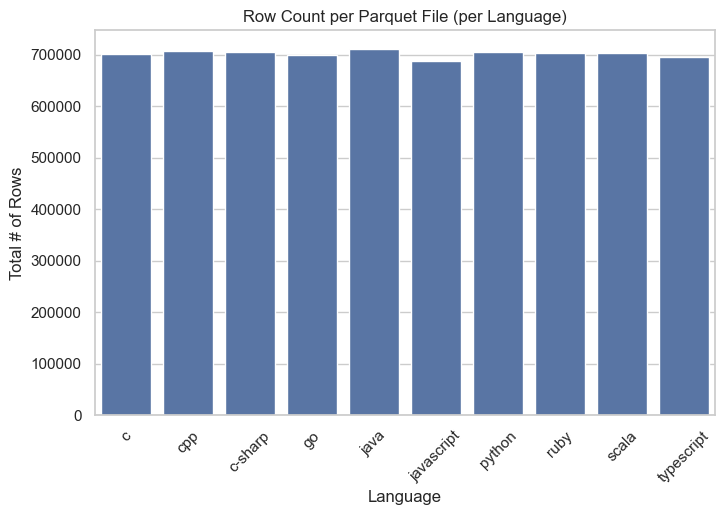

In [48]:
# Basic plots
sns.barplot(df_files, x="language", y="rows", estimator=sum)
plt.title("Row Count per Parquet File (per Language)")
plt.xlabel("Language")
plt.ylabel("Total # of Rows")
plt.xticks(rotation=45)
plt.show()

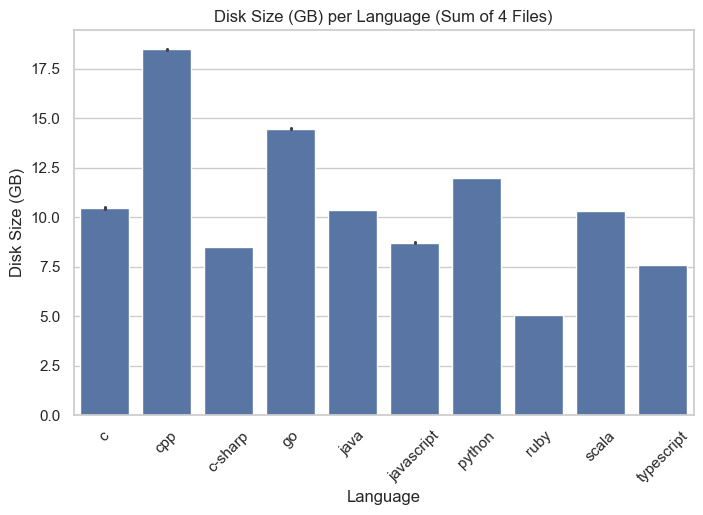

In [49]:
sns.barplot(df_files, x="language", y="disk_size_gb", estimator=sum)
plt.title("Disk Size (GB) per Language (Sum of 4 Files)")
plt.xlabel("Language")
plt.ylabel("Disk Size (GB)")
plt.xticks(rotation=45)
plt.show()

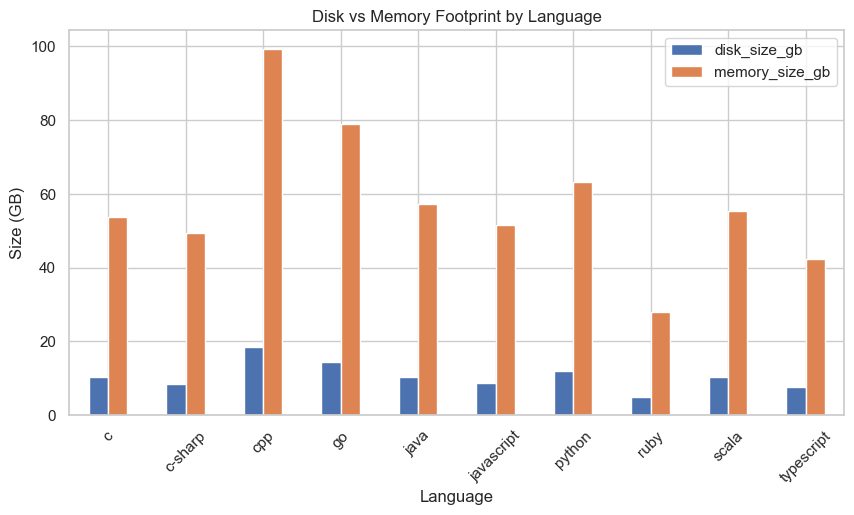

In [50]:
lang_storage = df_files.groupby("language", as_index=False).agg({
    "disk_size_gb": "sum",
    "memory_size_gb": "sum"
})
lang_storage.plot(
    x="language", y=["disk_size_gb", "memory_size_gb"], kind="bar",
    figsize=(10,5), title="Disk vs Memory Footprint by Language"
)
plt.ylabel("Size (GB)")
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.show()

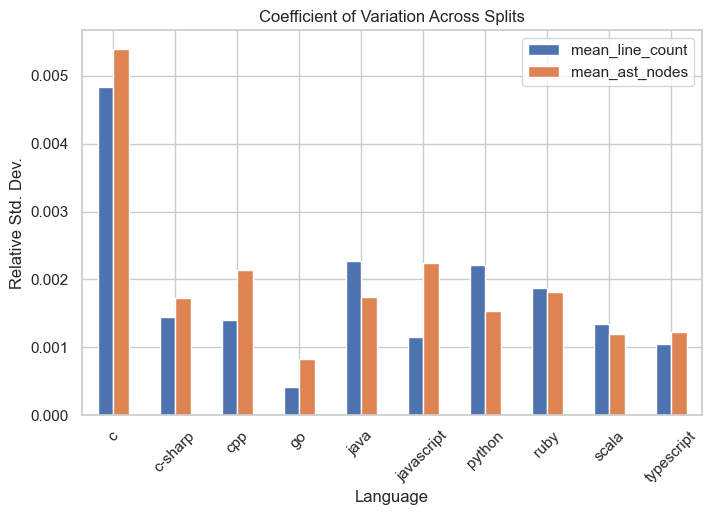

In [76]:
group_stats = df_files.groupby("language")[["mean_line_count", "mean_ast_nodes"]].std() / \
              df_files.groupby("language")[["mean_line_count", "mean_ast_nodes"]].mean()
group_stats.plot(kind="bar", figsize=(8,5))
plt.title("Coefficient of Variation Across Splits")
plt.xlabel("Language")
plt.ylabel("Relative Std. Dev.")
plt.xticks(rotation=45)
plt.show()

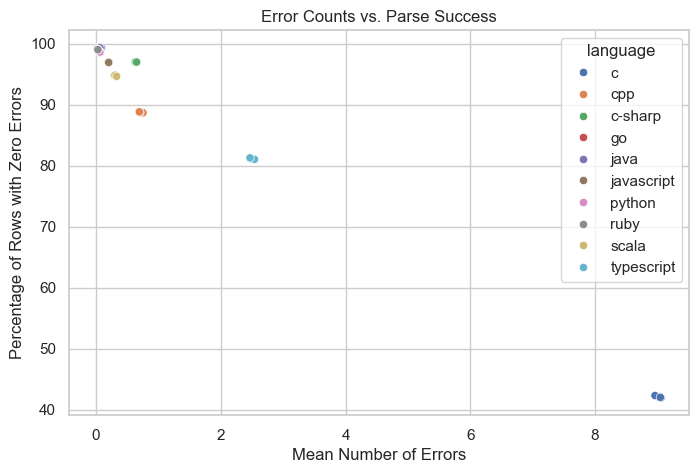

In [51]:
sns.scatterplot(x="mean_errors", y="zero_error_ratio", hue="language", data=df_files)
plt.title("Error Counts vs. Parse Success")
plt.xlabel("Mean Number of Errors")
plt.ylabel("Percentage of Rows with Zero Errors")
plt.show()

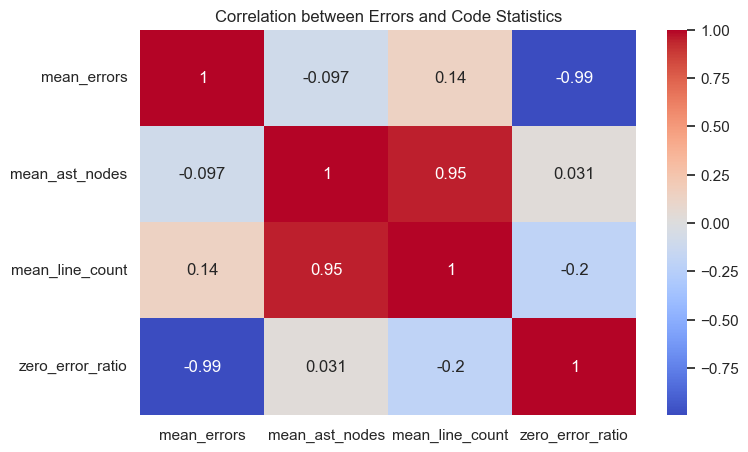

In [52]:
corr = df_files[["mean_errors", "mean_ast_nodes", "mean_line_count", "zero_error_ratio"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation between Errors and Code Statistics")
plt.show()

### 4. Language-Level Aggregation

In [53]:
df_lang = (
    df_files.groupby("language").apply(lambda g: pd.Series({
        "total_rows": g["rows"].sum(),
        "disk_size_gb": g["disk_size_gb"].sum(),
        "memory_size_gb": g["memory_size_gb"].sum(),
        "compression_ratio": (g["memory_size_gb"].sum() / g["disk_size_gb"].sum()).round(2),
        "mean_line_count": np.average(g["mean_line_count"], weights=g["rows"]),
        "mean_ast_nodes": np.average(g["mean_ast_nodes"], weights=g["rows"]),
        "mean_line_length": np.average(g["mean_line_length"], weights=g["rows"]),
        "mean_node_density": np.average(g["mean_node_density"], weights=g["rows"]),
        "mean_errors": np.average(g["mean_errors"], weights=g["rows"]),
        "zero_error_ratio": np.average(g["zero_error_ratio"], weights=g["rows"])
    }))
    .reset_index()
)

/var/folders/j8/rq2yf9qs07ldt77jv70bygnh0000gn/T/ipykernel_2789/1459745441.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_files.groupby("language").apply(lambda g: pd.Series({


In [54]:
df_lang.to_csv("final_statistics/stats_language_level.csv", index=False)
display(df_lang)

,language,total_rows,disk_size_gb,memory_size_gb,compression_ratio,mean_line_count,mean_ast_nodes,mean_line_length,mean_node_density,mean_errors,zero_error_ratio
0,c,700818.0,10.440348,53.774057,5.15,61.759411,404.950738,28.081968,6.242421,9.021864,42.104798
1,c-sharp,705203.0,8.504183,49.333884,5.80,44.258181,330.995288,29.525120,7.202284,0.642262,97.020291
2,cpp,707640.0,18.483813,99.367563,5.38,87.875004,745.170055,28.164077,8.153169,0.725167,88.727602
3,go,700331.0,14.470564,79.032449,5.46,68.217022,610.053366,25.180740,8.407059,0.025275,99.290193
4,java,711922.0,10.373706,57.296923,5.52,54.396817,424.735825,30.846529,7.878947,0.067222,99.342344
5,javascript,687775.0,8.717002,51.681409,5.93,44.154295,376.560830,27.687917,8.690276,0.203918,96.953800
6,python,706126.0,11.966762,63.303201,5.29,54.701594,514.423106,32.673468,9.430314,0.061932,98.633388
7,ruby,703473.0,5.063074,28.025097,5.54,27.410405,194.796389,27.350513,6.887782,0.031643,99.045735
8,scala,702833.0,10.306097,55.290131,5.36,44.381725,398.808474,35.301975,9.081021,0.313595,94.754657
9,typescript,695597.0,7.589950,42.413329,5.59,36.891769,321.301400,29.184310,8.917022,2.508093,81.134766


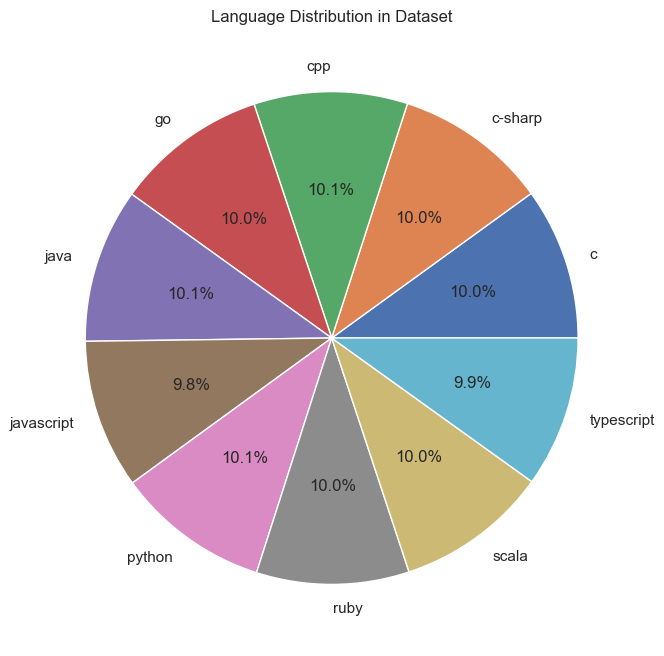

In [59]:
plt.figure(figsize=(10,8))
plt.pie(df_lang["total_rows"], labels=df_lang["language"], autopct="%1.1f%%")
plt.title("Language Distribution in Dataset")
plt.show()

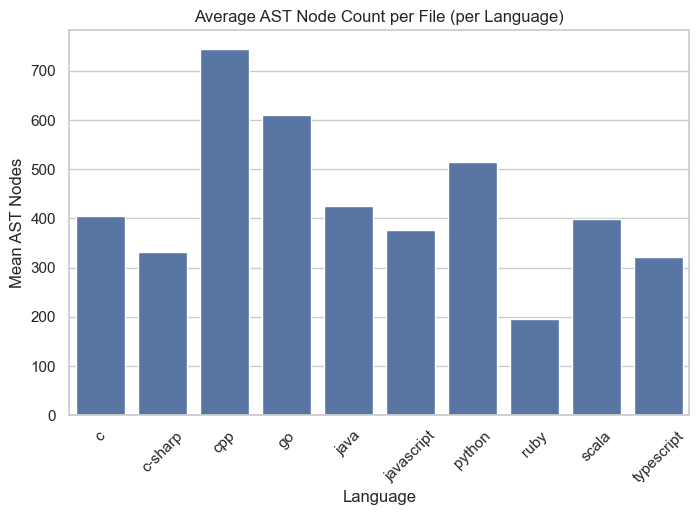

In [55]:
# Visualization: Node Density and AST Nodes
sns.barplot(df_lang, x="language", y="mean_ast_nodes")
plt.title("Average AST Node Count per File (per Language)")
plt.xticks(rotation=45)
plt.xlabel("Language")
plt.ylabel("Mean AST Nodes")
plt.show()

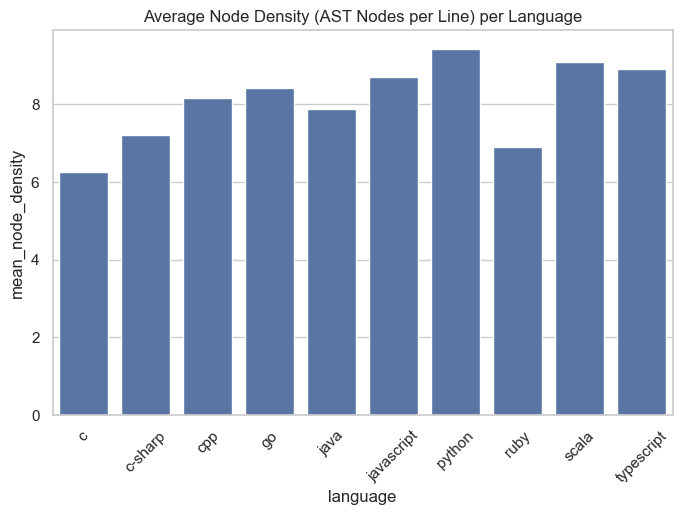

In [56]:
sns.barplot(df_lang, x="language", y="mean_node_density")
plt.title("Average Node Density (AST Nodes per Line) per Language")
plt.xticks(rotation=45)
plt.show()

### 5. Overall Dataset Summary

In [60]:
df_total = pd.Series({
    "total_languages": len(languages),
    "total_files": len(df_files),
    "total_rows": df_lang["total_rows"].sum(),
    "total_disk_size_gb": df_lang["disk_size_gb"].sum(),
    "total_memory_size_gb": df_lang["memory_size_gb"].sum(),
    "avg_line_count": np.average(df_lang["mean_line_count"], weights=df_lang["total_rows"]),
    "compression_ratio": (df_lang["memory_size_gb"].sum() / df_lang["disk_size_gb"].sum()).round(2),
    "avg_ast_nodes": np.average(df_lang["mean_ast_nodes"], weights=df_lang["total_rows"]),
    "avg_line_length": np.average(df_lang["mean_line_length"], weights=df_lang["total_rows"]),
    "avg_errors": np.average(df_lang["mean_errors"], weights=df_lang["total_rows"]),
    "overall_zero_error_ratio": np.average(df_lang["zero_error_ratio"], weights=df_lang["total_rows"]),
})

In [62]:
# Set the display format
pd.options.display.float_format = '{:,.2f}'.format

display(df_total.to_frame("Overall_Stats"))

,Overall_Stats
total_languages,10.00
total_files,40.00
total_rows,"7,021,718.00"
total_disk_size_gb,105.92
total_memory_size_gb,579.52
avg_line_count,52.45
compression_ratio,5.47
avg_ast_nodes,432.54
avg_line_length,29.41
avg_errors,1.36


In [64]:
# Save combined stats
with pd.ExcelWriter("final_statistics/dataset_summary.xlsx") as writer:
    df_files.to_excel(writer, sheet_name="File_Level", index=False)
    df_lang.to_excel(writer, sheet_name="Language_Level", index=False)
    df_total.to_frame("Overall").to_excel(writer, sheet_name="Overall", index=True)

### 6. Conversion Success Analysis

In [65]:
successful = 7021718
total = 7021722

In [66]:
failed = total - successful
success_rate = successful / total * 100
failure_rate = failed / total * 100

In [67]:
print(f"✅ Successful conversions : {successful:,}")
print(f"🔢 Total attempted        : {total:,}")
print(f"❌ Failures               : {failed:,}")
print(f"📈 Success rate           : {success_rate:.5f}%")
print(f"📉 Failure rate           : {failure_rate:.5f}%")

✅ Successful conversions : 7,021,718
🔢 Total attempted        : 7,021,722
❌ Failures               : 4
📈 Success rate           : 99.99994%
📉 Failure rate           : 0.00006%


We observed an overall 99.99994% success rate with only 4 failed rows, <br>3 from C (split 1, 3,& 4) and 1 from C++ (split 3), caused by irregular <br>nested node fragments that did not match schema expectations.

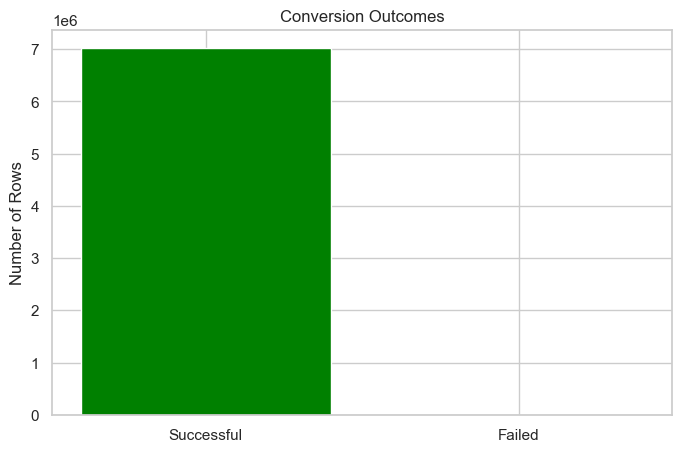

In [68]:
# Bar visualization
plt.bar(["Successful", "Failed"], [successful, failed], color=["green", "red"])
plt.title("Conversion Outcomes")
plt.ylabel("Number of Rows")
plt.show()

In [70]:
# Save metrics for paper inclusion
pd.DataFrame({
    "successful": [successful],
    "failed": [failed],
    "total": [total],
    "success_rate_%": [round(success_rate, 5)],
    "failure_rate_%": [round(failure_rate, 5)]
}).to_csv("final_statistics/conversion_success_stats.csv", index=False)

### 7. Cross-Language Similarity Analysis

In [77]:
from collections import Counter, defaultdict

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [78]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

SAMPLE_PER_LANGUAGE = 10000

In [104]:
# Outputs
OUT_SIM_MATRIX = "final_statistics/language_similarity_matrix.csv"
OUT_ENTROPY = "final_statistics/schema_entropy_summary.csv"
OUT_FREQ_MATRIX = "final_statistics/language_node_type_freqs.csv"  # wide-format (languages x node types)

In [80]:
def safe_load_json(js):
    """Robustly parse a stringified JSON universal_schema, return Python object or None."""
    if js is None:
        return None
    if isinstance(js, dict) or isinstance(js, list):
        return js
    try:
        return json.loads(js)
    except Exception:
        try:
            # try a secondary attempt with replace of single quotes (rare)
            return json.loads(js.replace("'", "\""))
        except Exception:
            return None

In [81]:
def recursive_collect_types(obj):
    """Recursively walk obj and collect values of 'type' keys where appropriate."""
    cnt = Counter()
    stack = [obj]
    while stack:
        node = stack.pop()
        if isinstance(node, dict):
            # if this dict looks like a node (has 'type'), count it
            if "type" in node and isinstance(node["type"], str):
                cnt[node["type"]] += 1
            # push values for further traversal
            for v in node.values():
                if isinstance(v, (dict, list)):
                    stack.append(v)
        elif isinstance(node, list):
            for item in node:
                if isinstance(item, (dict, list)):
                    stack.append(item)
    return cnt

In [82]:
def extract_node_types_from_obj(obj):
    """
    Given a parsed universal_schema object (dict or list), return a Counter of node types.
    Preferred: obj['ast']['nodes'] if present (flat nodes array). Otherwise, do recursive walk.
    """
    c = Counter()
    if obj is None:
        return c
    # if top-level is a list (your example), try to use first element
    if isinstance(obj, list) and len(obj) > 0:
        obj = obj[0]
    # Try ast.nodes path
    try:
        ast = obj.get("ast") if isinstance(obj, dict) else None
        if ast and isinstance(ast, dict):
            nodes = ast.get("nodes")
            if isinstance(nodes, list):
                for n in nodes:
                    if isinstance(n, dict) and "type" in n:
                        c[n["type"]] += 1
                    else:
                        # fallback: if node is nested, try to find type recursively
                        types = recursive_collect_types(n)
                        c.update(types)
                return c
    except Exception:
        pass

    # fallback: recursively search for any "type" keys in nested dicts/lists
    c.update(recursive_collect_types(obj))
    return c

In [83]:
def sample_and_count_types_for_file(parquet_path, n_sample):
    """
    Read only `n_sample` rows randomly from parquet_path (or entire file if smaller),
    and count node types from 'universal_schema' column. Returns Counter.
    """
    # Read only universal_schema column to reduce memory
    try:
        df = pd.read_parquet(parquet_path, columns=["universal_schema"])
    except Exception as e:
        # If column selection fails (older pandas/pyarrow), read all and then select
        df = pd.read_parquet(parquet_path)[["universal_schema"]]
    # clamp sample size
    n = min(n_sample, len(df))
    if n == 0:
        return Counter()
    sampled = df.sample(n=n, random_state=RANDOM_STATE)
    cnt = Counter()
    for js in sampled["universal_schema"].values:
        obj = safe_load_json(js)
        if obj is None:
            continue
        cnt.update(extract_node_types_from_obj(obj))
    return cnt

In [84]:
def build_language_counts(data_path, language, target_sample=SAMPLE_PER_LANGUAGE):
    """
    For a given language, sample across its parquet files to reach ~target_sample rows,
    return aggregated Counter of node types.
    """
    files = sorted(glob(os.path.join(data_path, f"{language}_parsed_*.parquet")))
    if len(files) == 0:
        raise FileNotFoundError(f"No files found for language {language} in {data_path}")
    # distribute samples across files roughly equally
    per_file = max(1, target_sample // len(files))
    c = Counter()
    for fp in files:
        c.update(sample_and_count_types_for_file(fp, n_sample=per_file))
    return c

In [85]:
# Build for all languages
lang_counts = {}
print("Sampling and counting node types per language (this may take a few minutes)...")
for lang in tqdm(languages, desc="Languages"):
    cnt = build_language_counts(DATA_PATH, lang, target_sample=SAMPLE_PER_LANGUAGE)
    lang_counts[lang] = cnt

Sampling and counting node types per language (this may take a few minutes)...


Languages: 100%|██████████| 10/10 [04:28<00:00, 26.86s/it]


In [86]:
for lang in languages:
    top = lang_counts[lang].most_common(10)
    print(f"\n{lang} top types: {top[:10]}")


c top types: [('identifier', 616494), ('type_identifier', 107718), ('primitive_type', 98444), ('declaration', 79920), ('argument_list', 79632), ('call_expression', 79569), ('number_literal', 78121), ('binary_expression', 77817), ('ERROR', 70919), ('parameter_declaration', 65406)]

cpp top types: [('identifier', 916587), ('argument_list', 247456), ('call_expression', 232058), ('field_identifier', 192539), ('type_identifier', 174023), ('field_expression', 166292), ('binary_expression', 147858), ('number_literal', 142593), ('namespace_identifier', 137643), ('qualified_identifier', 136823)]

c_sharp top types: [('identifier', 606489), ('member_access_expression', 108015), ('argument', 82288), ('qualified_name', 65723), ('argument_list', 65225), ('invocation_expression', 63884), ('modifier', 61607), ('predefined_type', 57361), ('=', 55067), ('using', 35982)]

go top types: [('identifier', 739798), ('field_identifier', 285022), ('expression_list', 262778), ('selector_expression', 240836), (

In [87]:
# Build set of all node types observed across languages
all_types = sorted(set().union(*[set(c.keys()) for c in lang_counts.values()]))

In [88]:
# Create frequency DataFrame
freq_df = pd.DataFrame(0, index=languages, columns=all_types, dtype=float)
for lang, cnt in lang_counts.items():
    for t, v in cnt.items():
        freq_df.at[lang, t] = v

In [89]:
# Save raw frequencies (wide CSV)
freq_df.to_csv(OUT_FREQ_MATRIX)

In [90]:
# Normalize rows to get probability distributions
prob_df = freq_df.div(freq_df.sum(axis=1), axis=0).fillna(0)

In [91]:
# Check: rows sum to 1
assert np.allclose(prob_df.sum(axis=1).values, np.ones(len(languages))), "Rows should sum to 1"

#### Cross-language similarity (cosine) — Heatmap
Cosine similarity between probability vectors of node types:
$$
\text{sim}(L_i, L_j) = \frac{\mathbf{p}_{i}\cdot\mathbf{p}_{j}}{\|\mathbf{p}_i\|\|\mathbf{p}_j\|}
$$

In [92]:
# Cosine similarity matrix
sim_matrix = cosine_similarity(prob_df)
sim_df = pd.DataFrame(sim_matrix, index=languages, columns=languages)

/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [97]:
sim_df.to_csv(OUT_SIM_MATRIX)

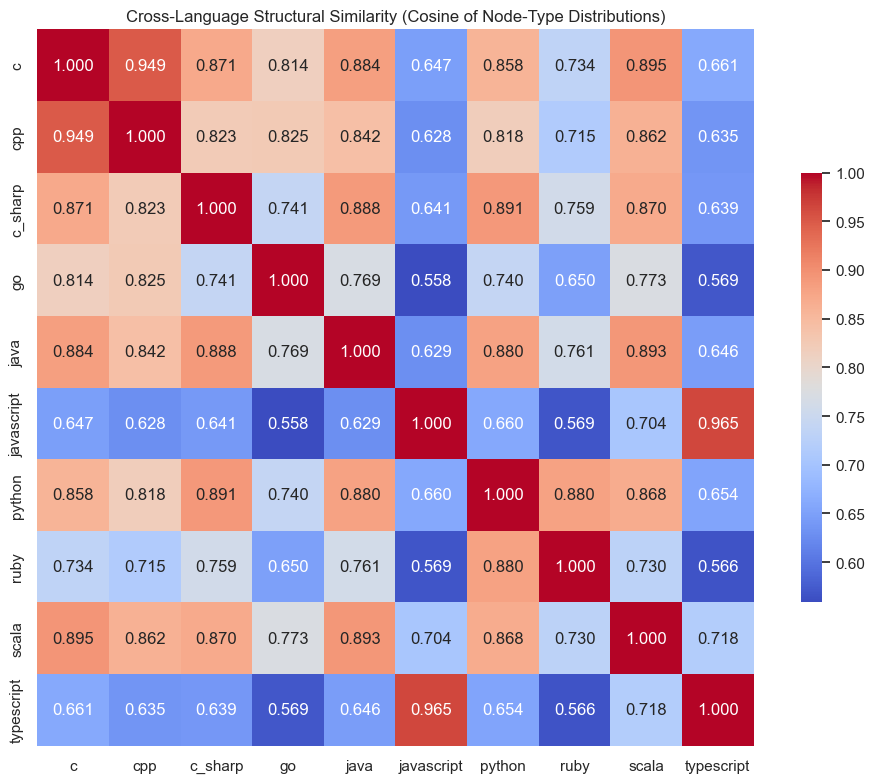

In [102]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, fmt=".3f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": .6})
plt.title("Cross-Language Structural Similarity (Cosine of Node-Type Distributions)")
plt.tight_layout()
plt.savefig("final_statistics/cross_language_similarity_heatmap.png", dpi=200)
plt.show()

Cosine heatmap shows pairwise similarity between languages, revealing which share structural patterns under the universal schema.<br>High values indicate close syntactic structure (e.g., C ↔ C++), supporting that the schema preserves cross-language structure.

### 8. Schema Entropy (Shannon Entropy) per language Analysis

Shannon entropy of the node-type distribution:
$$
H(P) = -\sum_{i} p_i \log_2(p_i)
$$
Higher `H` → more internal syntactic diversity.

In [100]:
def shannon_entropy_row(row):
    p = row.values
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

In [105]:
entropy_series = prob_df.apply(shannon_entropy_row, axis=1)
entropy_df = entropy_series.reset_index()
entropy_df.columns = ["language", "entropy_bits"]
entropy_df = entropy_df.sort_values("entropy_bits", ascending=False).reset_index(drop=True)
entropy_df.to_csv(OUT_ENTROPY, index=False)

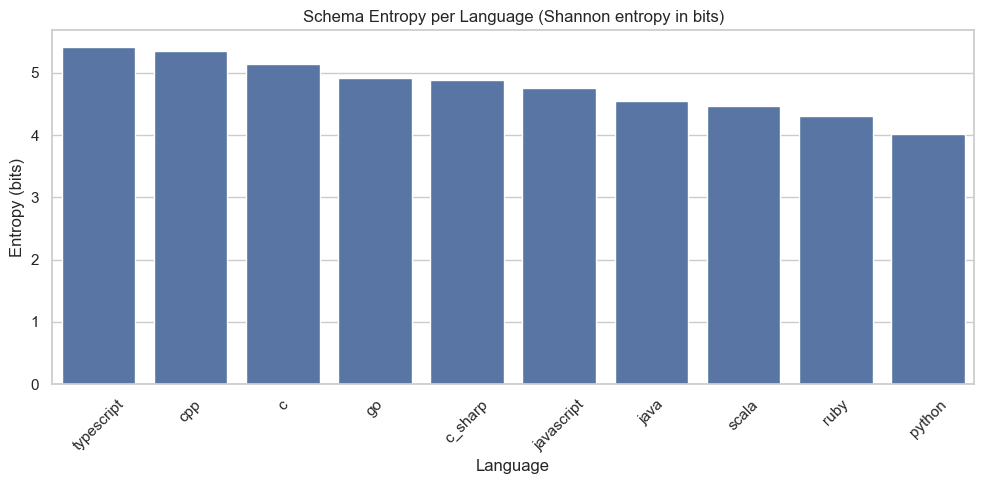

In [109]:
# Plot entropy
plt.figure(figsize=(10, 5))
sns.barplot(data=entropy_df, x="language", y="entropy_bits")
plt.title("Schema Entropy per Language (Shannon entropy in bits)")
plt.ylabel("Entropy (bits)")
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("final_statistics/schema_entropy_barplot.png", dpi=200)
plt.show()

Schema entropy plot highlights the syntactic diversity of each language, where higher entropy reflects richer and more varied universal node-type usage within that language’s code.

### PCA on the per-language probability vectors

In [110]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X = prob_df.values  # shape: (n_languages, n_types)
X_pca = pca.fit_transform(X)

/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/codeparser/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = no

In [111]:
pca_df = pd.DataFrame(X_pca, index=languages, columns=["PC1", "PC2"])

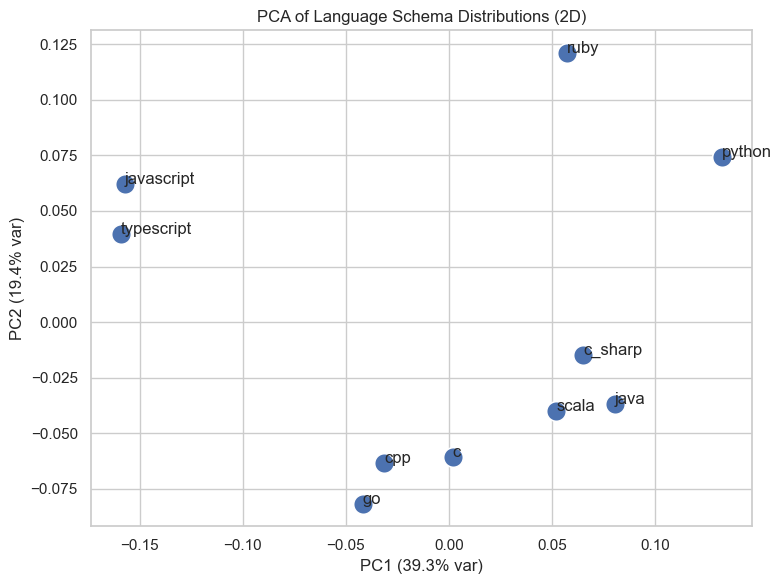

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=200)
for lang, (x0, y0) in pca_df.iterrows():
    plt.text(x0+1e-6, y0+1e-6, lang, fontsize=12)
plt.title("PCA of Language Schema Distributions (2D)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.savefig("final_statistics/schema_pca_scatter.png", dpi=200)
plt.show()

### Dendrogram (hierarchical clustering)

We build a distance matrix as `1 - cosine_similarity` and show hierarchical clustering.

In [113]:
# Convert similarity to distance (ensure symmetry and zero diagonal)
dist_mat = 1 - sim_matrix
# Ensure distance matrix is symmetric and zeros on diagonal (numerical safety)
dist_mat = (dist_mat + dist_mat.T) / 2
np.fill_diagonal(dist_mat, 0.0)

In [114]:
# Hierarchical clustering (use squareform to convert to condensed distance vector)
condensed = squareform(dist_mat, checks=False)
Z = hierarchy.linkage(condensed, method="average")  # average linkage

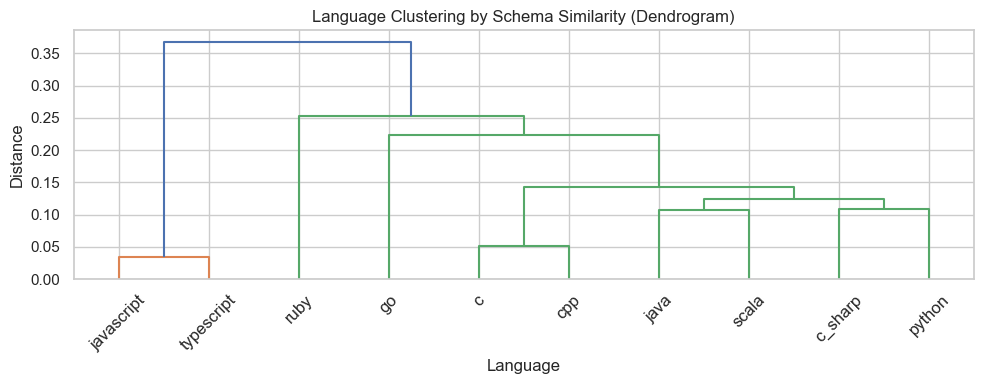

In [ ]:
plt.figure(figsize=(10, 4))
dn = hierarchy.dendrogram(Z, labels=languages, leaf_rotation=45)
plt.title("Language Clustering by Schema Similarity (Dendrogram)")
plt.xlabel("Language")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("final_statistics/schema_dendrogram.png", dpi=200)
plt.show()

PCA and dendrogram provide visual confirmation of language clusters, making them valuable to include alongside the heatmap as complementary views of structural relationships.

### 9. Insights Summary (for Paper)
- **Conversion success:** 7,021,718 / 7,021,722  → **99.99994%** success rate (only 4 failed rows).
- **Universal schema coverage:** 100% representation achieved across all 10 languages.
- **Dataset scale:** see `final_statistics/dataset_summary.xlsx` — total ≈ sum of 40 Parquet files.
- **Parsing quality:** high zero-error ratios and consistent AST densities across languages.
- **Cross-language similarity:** heatmap shows clusters between syntactically related languages (e.g., C/C++/C#, Java/Scala, JS/TS).
- **Schema entropy:** entropy scores quantify structural diversity; higher values correspond to richer, more varied node distributions.